In [21]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt

## Load Configs and Define Circuit

define FPGA config; this has timing information for the scheduler. For now it is fine to use the following default config

In [2]:
fpga_config = FPGAConfig()

load channel configs (firmware channel mapping + configuration, see [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for details)


In [3]:
channel_configs = load_channel_configs('channel_config.json')

Define the quantum circuit. Here, we show an example where all operations are done at the pulse-level, without explicitly referencing calibrated gates/parameters. For details on the QubiC circuit format and supported operations, see [compiler.py](https://gitlab.com/LBL-QubiC/distributed_processor/-/blob/master/python/distproc/compiler.py)

In [9]:
circuit = [
    #Allow qubit to decay to 0 state between shots
    {'name': 'delay', 't': 500.e-6}, 
    
    #play a pi/2 pulse on Q2
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.334704954261188, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q2.qdrv'}, 
    
    #scheduling barrier ensures that Q2 readout starts after the pulse
    {'name': 'barrier', 'scope': ['Q2.qdrv', 'Q2.rdrv', 'Q2.rdlo']},
    
    #play the readout drive pulse
    {'name': 'pulse', 'phase': 0, 'freq': 6658138379, 'amp': 0.019780537935570334, 'twidth': 2e-06,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q2.rdrv'},
    
    #add delay before demodulation (rdlo pulse)
    {'name': 'delay', 't': 600.e-9},
    
    #play the readout demodulation pulse
    {'name': 'pulse', 'phase': 0, 'freq': 6658138379, 'amp': 1, 'twidth': 2e-06,
     'env': {'env_func': 'square', 'paradict': {'phase': 0.0, 'amplitude': 1.0}},
     'dest': 'Q2.rdlo'}
]

## Compile and Assemble

Compile the program. Since we don't have any references to gates, we can pass None to the qchip argument. The output of the compile stage is a distributed processor assembly program, which consists of initialization/termination statements, as well as a list of scheduled pulses for each core. Our program only uses one processor core, scoped to channels `('Q2.qdrv', 'Q2.rdrv', 'Q2.rdlo')`.

In [12]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
compiled_prog.program

{('Q2.qdrv', 'Q2.rdrv', 'Q2.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 0.334704954261188,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 250005,
   'dest': 'Q2.qdrv'},
  {'op': 'pulse',
   'freq': 6658138379,
   'phase': 0,
   'amp': 0.019780537935570334,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}},
   'start_time': 250017,
   'dest': 'Q2.rdrv'},
  {'op': 'pulse',
   'freq': 6658138379,
   'phase': 0,
   'amp': 1,
   'env': {'env_func': 'square',
    'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}},
   'start_time': 250317,
   'dest': 'Q2.rdlo'},
  {'op': 'done_stb'}]}

Run the assembler to convert the above program into machine code that we can load onto the FPGA:

In [13]:
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)

## Connect to Server and Run Circuit

Now that we've defined our circuit and compiled it to machine code, we can submit it to the ZCU216 and run it.

Instantiate the runner client:

In [14]:
runner = rc.CircuitRunnerClient(ip='192.168.1.247', port=9095)

Submit the circuit to the server, and collect 5000 shots: 

In [24]:
s11 = runner.run_circuit_batch([raw_asm], 5000, delay_per_shot=0)

A dictionary of downconverted + integrated complex (IQ) values is returned for each loaded channel. In this case, we only performed drive + readout on Q2, so only channel '1' (corresponding to the core_ind of Q2.rdlo) was returned.

In [25]:
s11.keys()

dict_keys(['1'])

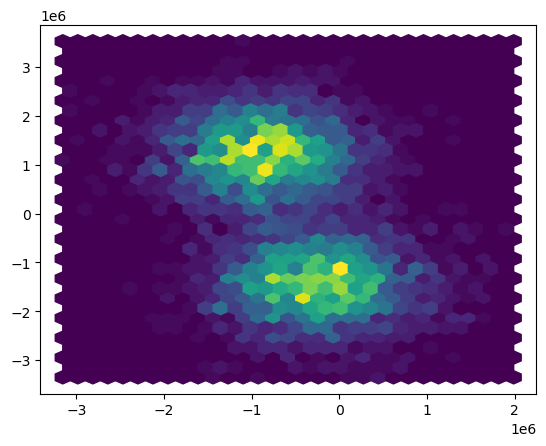

In [27]:
plt.hexbin(s11['1'].real, s11['1'].imag, gridsize=30)